In [3]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

import matplotlib.image as mpimg
from skimage.io import imread, imshow
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage
#import Tensorflow namespaces
import seaborn as sns
import optuna


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import sklearn.metrics as metrics


from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
import optuna_dashboard

import matplotlib.pyplot as plt

import pickle
import optuna 



from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
# GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

c:\Users\domin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#load the  dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()




print(X_train.shape)
print(y_train.shape)








(50000, 32, 32, 3)
(50000, 1)


In [5]:

#check the number of images in each set
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')





50000 train samples
10000 test samples


In [6]:
#preprocess 

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

#one hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#split the data into train and validation
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


#check the shape of the data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)










(40000, 32, 32, 3)
(40000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [7]:
#helper functions to plot training of baseline model

# Plot history
def histplot(history, name):
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    print(fig)

    axs[0].plot(history.history['loss'],'red',linewidth=3.0, label="loss")
    axs[0].plot(history.history['val_loss'],'blue',linewidth=3.0, label="val_loss")
    axs[0].legend()
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('Training error')
    axs[0].set_ylim((0,1.5))
    axs[0].grid()
    axs[0].set_title(name)

    axs[1].plot(history.history['accuracy'],'red',linewidth=3.0, label="accuracy")
    axs[1].plot(history.history['val_accuracy'],'blue',linewidth=3.0, label="val_accuracy")
    axs[1].legend()
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].grid()
    fig.savefig(name+'.png')


def PlotRoc_pos(probs, y_test):
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.suptitle('Receiver Operating Characteristic Positive class')
    
    ax[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax[0].legend(loc = 'lower right')
    ax[0].plot([0, 1], [0, 1],'r--')
    ax[0].set_xlim([0, 1])
    ax[0].set_ylim([0, 1])
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].grid()
    
    ax[1].plot(threshold, fpr, label='fpr')
    ax[1].plot(threshold, tpr, label='tpr')
    ax[1].legend()
    ax[1].grid()
    ax[1].set_xlim([0, 1])
    ax[1].set_ylim([0, 1])
    ax[1].set_ylabel('Rate')
    ax[1].set_xlabel('Threshold')
    plt.show()
    return fpr, tpr, threshold 
    
def PlotRoc_neg(probs, y_test):

    preds = probs[:,1]
    fnr, tnr, threshold = metrics.roc_curve(y_test, preds, pos_label=0)
    roc_auc = metrics.auc(fnr, tnr)

    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.suptitle('Receiver Operating Characteristic Negative class')
    
    ax[0].plot(fnr, tnr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax[0].legend(loc = 'lower right')
    ax[0].plot([0, 1], [0, 1],'r--')
    ax[0].set_xlim([0, 1])
    ax[0].set_ylim([0, 1])
    ax[0].set_ylabel('True Negative Rate')
    ax[0].set_xlabel('False Negative Rate')
    ax[0].grid()
    
    ax[1].plot(threshold, fnr, label='fnr')
    ax[1].plot(threshold, tnr, label='tnr')
    ax[1].legend()
    ax[1].grid()
    ax[1].set_xlim([0, 1])
    ax[1].set_ylim([0, 1])
    ax[1].set_ylabel('Rate')
    ax[1].set_xlabel('Threshold')
    plt.show()
    return fnr, tnr, threshold

In [8]:
X_train.shape[1:]

(32, 32, 3)

### Base CNN model
We will start with a base Convolutional Neural network model.

By using early stopping callback, we can avoid overfitting and save time if the model is not improving.
We save the best model  with model checkpoint callback to use it later for testing.

In [56]:
# CNN model
# Convolutional Neural Network


# Convolutional Neural Network
batch_size = 32
num_classes = 10
epochs = 20

# create the model
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))



model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))



model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()



# Train the model


#checkpoint (save best model)
mc = ModelCheckpoint('best_model_base1.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
#early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience = 5)

model.save('best_model_base1_saved')




history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test) , shuffle=True, callbacks=[mc, es])














Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_192 (Conv2D)         (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_128 (MaxPooli  (None, 15, 15, 64)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_128 (Ba  (None, 15, 15, 64)       256       
 tchNormalization)                                               
                                                                 
 dropout_448 (Dropout)       (None, 15, 15, 64)        0         
                                                                 
 conv2d_193 (Conv2D)         (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_129 (MaxPooli  (None, 6, 6, 64)       

INFO:tensorflow:Assets written to: best_model_base1_saved\assets


INFO:tensorflow:Assets written to: best_model_base1_saved\assets


Epoch 1/20
1250/1250 [==============================] - ETA: 0s - loss: 1.8944 - accuracy: 0.2725
Epoch 1: val_accuracy improved from -inf to 0.42910, saving model to best_model_base1.h5
1250/1250 [==============================] - 46s 36ms/step - loss: 1.8944 - accuracy: 0.2725 - val_loss: 1.5597 - val_accuracy: 0.4291
Epoch 2/20
1250/1250 [==============================] - ETA: 0s - loss: 1.6012 - accuracy: 0.4090
Epoch 2: val_accuracy improved from 0.42910 to 0.46180, saving model to best_model_base1.h5
1250/1250 [==============================] - 43s 35ms/step - loss: 1.6012 - accuracy: 0.4090 - val_loss: 1.4709 - val_accuracy: 0.4618
Epoch 3/20
1249/1250 [============================>.] - ETA: 0s - loss: 1.4687 - accuracy: 0.4728
Epoch 3: val_accuracy improved from 0.46180 to 0.47340, saving model to best_model_base1.h5
1250/1250 [==============================] - 45s 36ms/step - loss: 1.4688 - accuracy: 0.4727 - val_loss: 1.5304 - val_accuracy: 0.4734
Epoch 4/20
1250/1250 [======

Figure(864x432)


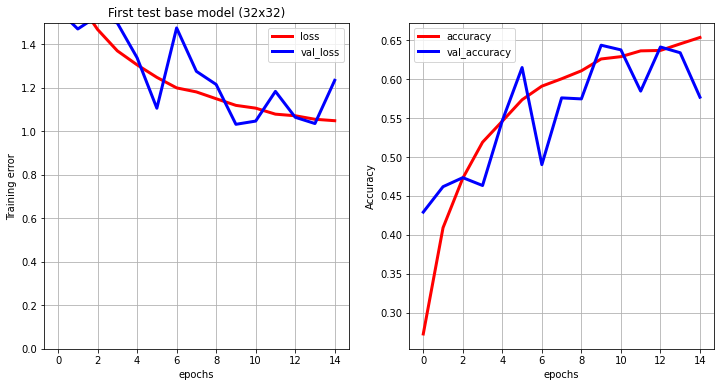

In [57]:
histplot(history, "First test base model (32x32)")    

In [58]:
# load best model
model.load_weights('best_model_base1.h5')

In [59]:
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))



# make prediction.
pred = model.predict(X_test)
print('Test accuracy: on test data', accuracy_score(y_test.argmax(axis=1), pred.argmax(axis=1)))





Train: 0.670, Test: 0.644
313/313 [==============================] - 3s 8ms/step
Test accuracy: on test data 0.6436


### Results of base model
The base model has an accuracy of around 64.36% 

## Gridsearch on model with Optuna
We now use optuna to search for the best hyperparameters for the model using grid search.


 1) we define the cnn model (model_gridsearch)<br>
 2) In the objective function we define the hyperparameters/search space we want to optimize and the model we want to optimize<br>
 2.1 We save the best model_weights and use pruning/ pruning_callback to stop the training if the accuracy is not improving to save time and resources<br>
 3) We then run the optuna study and print the best parameters and the best accuracy, as sampler we use GridSampler to indicate we want to use grid search
 4) We then load the best model weights and evaluate the model 


In [80]:

# CNN model
# Convolutional Neural Network optuna

def model_gridsearch():

    batch_size = 32
    num_classes = 10
    epochs = 10

    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.3))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))



    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    return model









In [81]:
# grid search met optuna
def objective(trial):
    model = model_gridsearch()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
   
    #grid search  space



    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_categorical('epochs', [10, 20, 30])
    dense_layer = trial.suggest_int('dense_layer', 1, 6)
    conv_layer = trial.suggest_int('conv_layer', 1, 5)
    dense_nodes = trial.suggest_categorical('dense_nodes', [32,64,128,256])
    conv_nodes = trial.suggest_categorical('conv_nodes',[ 8,16,32,64])
    dropout = trial.suggest_float('dropout', 0.1, 0.5)

    
    

    #checkpoint
    mc = ModelCheckpoint('best_model_optuna_gridsearch.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
   
    #pruning
    pruning_callback = optuna.integration.KerasPruningCallback(trial, 'val_accuracy')

    #early stopping
    # es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience = 5)
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,  validation_data=(X_test, y_test) , shuffle=True, callbacks=[mc, es, pruning_callback])


    
    #save model weights
    model.save('best_model_optuna_gridsearch1_saved')

    

    #save best model weights
    model.save_weights('best_model_optuna_gridsearch1_weights')

    
    return history.history['val_accuracy'][-1]



    



We run 20 trials here, but you can run more if you want. Here we set GridSampler to use Grid search.
For more information on Samplers, <br> have a look at the [Optuna sampler documentation](https://optuna.readthedocs.io/en/v2.0.0/reference/samplers.html)

In [83]:
    # run the grid search
study = optuna.create_study(direction='maximize', study_name='optuna_gridsearch1', storage='sqlite:///optuna_gridsearch1.db', load_if_exists=True, sampler=optuna.samplers.GridSampler )
study.optimize(objective, n_trials=20)

# print best parameters
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)



[I 2023-01-23 22:49:00,749] A new study created in RDB with name: optuna_gridsearch1
C:\Users\domin\AppData\Local\Temp\ipykernel_17804\1222758937.py:37: FutureWarning:

KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna.integration.TFKerasPruningCallback`



Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 1.8905 - accuracy: 0.2859
Epoch 1: val_accuracy improved from -inf to 0.39000, saving model to best_model_optuna_gridsearch.h5
1250/1250 [==============================] - 42s 33ms/step - loss: 1.8905 - accuracy: 0.2859 - val_loss: 1.6209 - val_accuracy: 0.3900
Epoch 2/10
1249/1250 [============================>.] - ETA: 0s - loss: 1.5684 - accuracy: 0.4297
Epoch 2: val_accuracy did not improve from 0.39000
1250/1250 [==============================] - 46s 37ms/step - loss: 1.5683 - accuracy: 0.4298 - val_loss: 1.8105 - val_accuracy: 0.3784
Epoch 3/10
1249/1250 [============================>.] - ETA: 0s - loss: 1.4504 - accuracy: 0.4836
Epoch 3: val_accuracy improved from 0.39000 to 0.50120, saving model to best_model_optuna_gridsearch.h5
1250/1250 [==============================] - 45s 36ms/step - loss: 1.4506 - accuracy: 0.4836 - val_loss: 1.3558 - val_accuracy: 0.5012
Epoch 4/10
1249/1250 [=======================

INFO:tensorflow:Assets written to: best_model_optuna_gridsearch1_saved\assets


INFO:tensorflow:Assets written to: best_model_optuna_gridsearch1_saved\assets
[I 2023-01-23 22:56:22,524] Trial 0 finished with value: 0.6521000266075134 and parameters: {'batch_size': 32, 'epochs': 10, 'dense_layer': 1, 'conv_layer': 5, 'dense_nodes': 256, 'conv_nodes': 8, 'dropout': 0.2}. Best is trial 0 with value: 0.6521000266075134.
C:\Users\domin\AppData\Local\Temp\ipykernel_17804\1222758937.py:37: FutureWarning:

KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna.integration.TFKerasPruningC

Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 1.8892 - accuracy: 0.2830
Epoch 1: val_accuracy improved from -inf to 0.42590, saving model to best_model_optuna_gridsearch.h5
1250/1250 [==============================] - 46s 36ms/step - loss: 1.8892 - accuracy: 0.2830 - val_loss: 1.5626 - val_accuracy: 0.4259
Epoch 2/10
1250/1250 [==============================] - ETA: 0s - loss: 1.5818 - accuracy: 0.4173
Epoch 2: val_accuracy improved from 0.42590 to 0.47480, saving model to best_model_optuna_gridsearch.h5
1250/1250 [==============================] - 46s 37ms/step - loss: 1.5818 - accuracy: 0.4173 - val_loss: 1.4220 - val_accuracy: 0.4748
Epoch 3/10
1249/1250 [============================>.] - ETA: 0s - loss: 1.4479 - accuracy: 0.4838
Epoch 3: val_accuracy improved from 0.47480 to 0.55870, saving model to best_model_optuna_gridsearch.h5
1250/1250 [==============================] - 46s 37ms/step - loss: 1.4478 - accuracy: 0.4839 - val_loss: 1.2693 - val_accuracy:

INFO:tensorflow:Assets written to: best_model_optuna_gridsearch1_saved\assets


INFO:tensorflow:Assets written to: best_model_optuna_gridsearch1_saved\assets
[I 2023-01-23 23:03:48,931] Trial 1 finished with value: 0.6578999757766724 and parameters: {'batch_size': 32, 'epochs': 30, 'dense_layer': 1, 'conv_layer': 4, 'dense_nodes': 64, 'conv_nodes': 8, 'dropout': 0.2}. Best is trial 1 with value: 0.6578999757766724.
C:\Users\domin\AppData\Local\Temp\ipykernel_17804\1222758937.py:37: FutureWarning:

KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna.integration.TFKerasPruningCa

Epoch 1/10
1249/1250 [============================>.] - ETA: 0s - loss: 1.8763 - accuracy: 0.2869
Epoch 1: val_accuracy improved from -inf to 0.33370, saving model to best_model_optuna_gridsearch.h5
1250/1250 [==============================] - 46s 36ms/step - loss: 1.8762 - accuracy: 0.2870 - val_loss: 1.8027 - val_accuracy: 0.3337
Epoch 2/10
1250/1250 [==============================] - ETA: 0s - loss: 1.5621 - accuracy: 0.4314
Epoch 2: val_accuracy improved from 0.33370 to 0.51350, saving model to best_model_optuna_gridsearch.h5
1250/1250 [==============================] - 43s 34ms/step - loss: 1.5621 - accuracy: 0.4314 - val_loss: 1.3578 - val_accuracy: 0.5135
Epoch 3/10
1249/1250 [============================>.] - ETA: 0s - loss: 1.4309 - accuracy: 0.4980
Epoch 3: val_accuracy did not improve from 0.51350
1250/1250 [==============================] - 45s 36ms/step - loss: 1.4306 - accuracy: 0.4981 - val_loss: 1.9771 - val_accuracy: 0.4169
Epoch 4/10
1249/1250 [=======================

INFO:tensorflow:Assets written to: best_model_optuna_gridsearch1_saved\assets


INFO:tensorflow:Assets written to: best_model_optuna_gridsearch1_saved\assets
[I 2023-01-23 23:11:18,174] Trial 2 finished with value: 0.6355999708175659 and parameters: {'batch_size': 64, 'epochs': 30, 'dense_layer': 3, 'conv_layer': 5, 'dense_nodes': 64, 'conv_nodes': 32, 'dropout': 0.5}. Best is trial 1 with value: 0.6578999757766724.
C:\Users\domin\AppData\Local\Temp\ipykernel_17804\1222758937.py:37: FutureWarning:

KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna.integration.TFKerasPruningC

Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 1.8755 - accuracy: 0.2923
Epoch 1: val_accuracy improved from -inf to 0.43480, saving model to best_model_optuna_gridsearch.h5
1250/1250 [==============================] - 46s 36ms/step - loss: 1.8755 - accuracy: 0.2923 - val_loss: 1.5669 - val_accuracy: 0.4348
Epoch 2/10
1249/1250 [============================>.] - ETA: 0s - loss: 1.5631 - accuracy: 0.4310
Epoch 2: val_accuracy improved from 0.43480 to 0.51260, saving model to best_model_optuna_gridsearch.h5
1250/1250 [==============================] - 49s 39ms/step - loss: 1.5631 - accuracy: 0.4311 - val_loss: 1.3807 - val_accuracy: 0.5126
Epoch 3/10
1250/1250 [==============================] - ETA: 0s - loss: 1.4278 - accuracy: 0.4932
Epoch 3: val_accuracy did not improve from 0.51260
1250/1250 [==============================] - 48s 38ms/step - loss: 1.4278 - accuracy: 0.4932 - val_loss: 1.4529 - val_accuracy: 0.4678
Epoch 4/10
1249/1250 [=======================

INFO:tensorflow:Assets written to: best_model_optuna_gridsearch1_saved\assets


INFO:tensorflow:Assets written to: best_model_optuna_gridsearch1_saved\assets
[I 2023-01-23 23:19:07,749] Trial 3 finished with value: 0.5989999771118164 and parameters: {'batch_size': 64, 'epochs': 20, 'dense_layer': 4, 'conv_layer': 2, 'dense_nodes': 64, 'conv_nodes': 8, 'dropout': 0.4}. Best is trial 1 with value: 0.6578999757766724.
C:\Users\domin\AppData\Local\Temp\ipykernel_17804\1222758937.py:37: FutureWarning:

KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna.integration.TFKerasPruningCa

Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 1.8917 - accuracy: 0.2778
Epoch 1: val_accuracy improved from -inf to 0.35770, saving model to best_model_optuna_gridsearch.h5
1250/1250 [==============================] - 47s 37ms/step - loss: 1.8917 - accuracy: 0.2778 - val_loss: 1.7621 - val_accuracy: 0.3577
Epoch 2/10
1250/1250 [==============================] - ETA: 0s - loss: 1.5911 - accuracy: 0.4161
Epoch 2: val_accuracy improved from 0.35770 to 0.48520, saving model to best_model_optuna_gridsearch.h5
1250/1250 [==============================] - 43s 34ms/step - loss: 1.5911 - accuracy: 0.4161 - val_loss: 1.4206 - val_accuracy: 0.4852
Epoch 3/10
1250/1250 [==============================] - ETA: 0s - loss: 1.4618 - accuracy: 0.4805
Epoch 3: val_accuracy improved from 0.48520 to 0.54480, saving model to best_model_optuna_gridsearch.h5
1250/1250 [==============================] - 41s 33ms/step - loss: 1.4618 - accuracy: 0.4805 - val_loss: 1.2785 - val_accuracy:

INFO:tensorflow:Assets written to: best_model_optuna_gridsearch1_saved\assets


INFO:tensorflow:Assets written to: best_model_optuna_gridsearch1_saved\assets
[I 2023-01-23 23:26:31,813] Trial 4 finished with value: 0.6478999853134155 and parameters: {'batch_size': 32, 'epochs': 10, 'dense_layer': 4, 'conv_layer': 3, 'dense_nodes': 64, 'conv_nodes': 32, 'dropout': 0.2}. Best is trial 1 with value: 0.6578999757766724.
C:\Users\domin\AppData\Local\Temp\ipykernel_17804\1222758937.py:37: FutureWarning:

KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna.integration.TFKerasPruningC

Epoch 1/10
1249/1250 [============================>.] - ETA: 0s - loss: 1.8809 - accuracy: 0.2872
Epoch 1: val_accuracy improved from -inf to 0.34530, saving model to best_model_optuna_gridsearch.h5


[I 2023-01-23 23:27:15,144] Trial 5 pruned. Trial was pruned at epoch 0.


Epoch 1/10
1249/1250 [============================>.] - ETA: 0s - loss: 1.9134 - accuracy: 0.2706
Epoch 1: val_accuracy improved from -inf to 0.38420, saving model to best_model_optuna_gridsearch.h5


[I 2023-01-23 23:27:58,524] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/10
1249/1250 [============================>.] - ETA: 0s - loss: 1.8852 - accuracy: 0.2869
Epoch 1: val_accuracy improved from -inf to 0.38120, saving model to best_model_optuna_gridsearch.h5


[I 2023-01-23 23:28:41,794] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/10
1249/1250 [============================>.] - ETA: 0s - loss: 1.9246 - accuracy: 0.2637
Epoch 1: val_accuracy improved from -inf to 0.34550, saving model to best_model_optuna_gridsearch.h5


[I 2023-01-23 23:29:26,640] Trial 8 pruned. Trial was pruned at epoch 0.


Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 1.8948 - accuracy: 0.2792
Epoch 1: val_accuracy improved from -inf to 0.37560, saving model to best_model_optuna_gridsearch.h5


[I 2023-01-23 23:30:11,551] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/10
1249/1250 [============================>.] - ETA: 0s - loss: 1.8879 - accuracy: 0.2836
Epoch 1: val_accuracy improved from -inf to 0.40140, saving model to best_model_optuna_gridsearch.h5
1250/1250 [==============================] - 40s 32ms/step - loss: 1.8876 - accuracy: 0.2837 - val_loss: 1.5552 - val_accuracy: 0.4014
Epoch 2/10
1250/1250 [==============================] - ETA: 0s - loss: 1.5823 - accuracy: 0.4256
Epoch 2: val_accuracy improved from 0.40140 to 0.49340, saving model to best_model_optuna_gridsearch.h5
1250/1250 [==============================] - 40s 32ms/step - loss: 1.5823 - accuracy: 0.4256 - val_loss: 1.4454 - val_accuracy: 0.4934
Epoch 3/10
1249/1250 [============================>.] - ETA: 0s - loss: 1.4468 - accuracy: 0.4888
Epoch 3: val_accuracy improved from 0.49340 to 0.50020, saving model to best_model_optuna_gridsearch.h5


[I 2023-01-23 23:32:12,322] Trial 10 pruned. Trial was pruned at epoch 2.


Epoch 1/10
1249/1250 [============================>.] - ETA: 0s - loss: 1.8906 - accuracy: 0.2864
Epoch 1: val_accuracy improved from -inf to 0.41490, saving model to best_model_optuna_gridsearch.h5
1250/1250 [==============================] - 40s 32ms/step - loss: 1.8902 - accuracy: 0.2865 - val_loss: 1.5677 - val_accuracy: 0.4149
Epoch 2/10
1249/1250 [============================>.] - ETA: 0s - loss: 1.5816 - accuracy: 0.4206
Epoch 2: val_accuracy improved from 0.41490 to 0.50490, saving model to best_model_optuna_gridsearch.h5
1250/1250 [==============================] - 41s 33ms/step - loss: 1.5819 - accuracy: 0.4205 - val_loss: 1.3721 - val_accuracy: 0.5049
Epoch 3/10
1250/1250 [==============================] - ETA: 0s - loss: 1.4463 - accuracy: 0.4852
Epoch 3: val_accuracy did not improve from 0.50490
1250/1250 [==============================] - 39s 31ms/step - loss: 1.4463 - accuracy: 0.4852 - val_loss: 1.4147 - val_accuracy: 0.4899
Epoch 4/10
1249/1250 [=======================

[I 2023-01-23 23:36:19,362] Trial 11 pruned. Trial was pruned at epoch 5.


Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 1.8794 - accuracy: 0.2880
Epoch 1: val_accuracy improved from -inf to 0.31570, saving model to best_model_optuna_gridsearch.h5


[I 2023-01-23 23:37:02,184] Trial 12 pruned. Trial was pruned at epoch 0.


Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 1.8847 - accuracy: 0.2878
Epoch 1: val_accuracy improved from -inf to 0.42140, saving model to best_model_optuna_gridsearch.h5
1250/1250 [==============================] - 45s 35ms/step - loss: 1.8847 - accuracy: 0.2878 - val_loss: 1.5600 - val_accuracy: 0.4214
Epoch 2/10
1250/1250 [==============================] - ETA: 0s - loss: 1.5726 - accuracy: 0.4281
Epoch 2: val_accuracy improved from 0.42140 to 0.52360, saving model to best_model_optuna_gridsearch.h5
1250/1250 [==============================] - 44s 35ms/step - loss: 1.5726 - accuracy: 0.4281 - val_loss: 1.3446 - val_accuracy: 0.5236
Epoch 3/10
1249/1250 [============================>.] - ETA: 0s - loss: 1.4299 - accuracy: 0.4949
Epoch 3: val_accuracy improved from 0.52360 to 0.56500, saving model to best_model_optuna_gridsearch.h5
1250/1250 [==============================] - 42s 34ms/step - loss: 1.4302 - accuracy: 0.4948 - val_loss: 1.2468 - val_accuracy:

INFO:tensorflow:Assets written to: best_model_optuna_gridsearch1_saved\assets


INFO:tensorflow:Assets written to: best_model_optuna_gridsearch1_saved\assets
[I 2023-01-23 23:44:00,791] Trial 13 finished with value: 0.6787999868392944 and parameters: {'batch_size': 32, 'epochs': 20, 'dense_layer': 3, 'conv_layer': 1, 'dense_nodes': 256, 'conv_nodes': 64, 'dropout': 0.1}. Best is trial 13 with value: 0.6787999868392944.
C:\Users\domin\AppData\Local\Temp\ipykernel_17804\1222758937.py:37: FutureWarning:

KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna.integration.TFKerasPruni

Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 1.9013 - accuracy: 0.2791
Epoch 1: val_accuracy improved from -inf to 0.28340, saving model to best_model_optuna_gridsearch.h5


[I 2023-01-23 23:44:47,124] Trial 14 pruned. Trial was pruned at epoch 0.


Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 1.8985 - accuracy: 0.2826
Epoch 1: val_accuracy improved from -inf to 0.41130, saving model to best_model_optuna_gridsearch.h5
1250/1250 [==============================] - 47s 37ms/step - loss: 1.8985 - accuracy: 0.2826 - val_loss: 1.6295 - val_accuracy: 0.4113
Epoch 2/10
1249/1250 [============================>.] - ETA: 0s - loss: 1.5793 - accuracy: 0.4252
Epoch 2: val_accuracy improved from 0.41130 to 0.50960, saving model to best_model_optuna_gridsearch.h5
1250/1250 [==============================] - 44s 35ms/step - loss: 1.5794 - accuracy: 0.4252 - val_loss: 1.4044 - val_accuracy: 0.5096
Epoch 3/10
1249/1250 [============================>.] - ETA: 0s - loss: 1.4573 - accuracy: 0.4835
Epoch 3: val_accuracy improved from 0.50960 to 0.52600, saving model to best_model_optuna_gridsearch.h5
1250/1250 [==============================] - 43s 35ms/step - loss: 1.4574 - accuracy: 0.4834 - val_loss: 1.3229 - val_accuracy:

[I 2023-01-23 23:47:44,756] Trial 15 pruned. Trial was pruned at epoch 3.


Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 1.8734 - accuracy: 0.2875
Epoch 1: val_accuracy improved from -inf to 0.37890, saving model to best_model_optuna_gridsearch.h5


[I 2023-01-23 23:48:33,331] Trial 16 pruned. Trial was pruned at epoch 0.


Epoch 1/10
1249/1250 [============================>.] - ETA: 0s - loss: 1.8887 - accuracy: 0.2776
Epoch 1: val_accuracy improved from -inf to 0.34010, saving model to best_model_optuna_gridsearch.h5


[I 2023-01-23 23:49:18,080] Trial 17 pruned. Trial was pruned at epoch 0.


Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 1.8895 - accuracy: 0.2826
Epoch 1: val_accuracy improved from -inf to 0.42080, saving model to best_model_optuna_gridsearch.h5
1250/1250 [==============================] - 43s 33ms/step - loss: 1.8895 - accuracy: 0.2826 - val_loss: 1.5706 - val_accuracy: 0.4208
Epoch 2/10
1249/1250 [============================>.] - ETA: 0s - loss: 1.5772 - accuracy: 0.4280
Epoch 2: val_accuracy did not improve from 0.42080


[I 2023-01-23 23:50:42,019] Trial 18 pruned. Trial was pruned at epoch 1.


Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 1.8933 - accuracy: 0.2793
Epoch 1: val_accuracy improved from -inf to 0.42460, saving model to best_model_optuna_gridsearch.h5
1250/1250 [==============================] - 41s 32ms/step - loss: 1.8933 - accuracy: 0.2793 - val_loss: 1.5812 - val_accuracy: 0.4246
Epoch 2/10
1250/1250 [==============================] - ETA: 0s - loss: 1.5850 - accuracy: 0.4181
Epoch 2: val_accuracy improved from 0.42460 to 0.46470, saving model to best_model_optuna_gridsearch.h5


[I 2023-01-23 23:52:02,351] Trial 19 pruned. Trial was pruned at epoch 1.


Number of finished trials: 20
Best trial: {'batch_size': 32, 'conv_layer': 1, 'conv_nodes': 64, 'dense_layer': 3, 'dense_nodes': 256, 'dropout': 0.1, 'epochs': 20}


In [84]:
# # plot
# optuna.visualization.plot_optimization_history(study)
# optuna.visualization.plot_slice(study)
# optuna.visualization.plot_param_importances(study)

def show_result(study):

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))



In [85]:
show_result(study)

Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  14
  Number of complete trials:  6
Best trial:
  Value:  0.6787999868392944
  Params: 
    batch_size: 32
    conv_layer: 1
    conv_nodes: 64
    dense_layer: 3
    dense_nodes: 256
    dropout: 0.1
    epochs: 20


In [86]:
# test the best model after loading the best model weights
model = model_gridsearch()
model.load_weights('best_model_optuna_gridsearch1_weights')
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])





Test loss: 0.9558917880058289
Test accuracy: 0.6787999868392944


Optuna has some easy to use visialization tools. We can use the optuna.visualization.plot_optimization_history to plot the optimization history of the study.
For more information on visualization, have a look at the [Optuna visualization documentation](https://optuna.readthedocs.io/en/stable/reference/visualization/index.html)

In [91]:
# # plot
optuna.visualization.plot_optimization_history(study)







In [92]:
#show result of study like duration, value, state
df = study.trials_dataframe(attrs=("number", "value",   'duration', 'state'))
print(df)

#total duration of model training
print('Total duration of model training: ', df['duration'].sum())


    number   value               duration     state
0        0  0.6521 0 days 00:07:21.707995  COMPLETE
1        1  0.6579 0 days 00:07:26.346141  COMPLETE
2        2  0.6356 0 days 00:07:29.210976  COMPLETE
3        3  0.5990 0 days 00:07:49.544016  COMPLETE
4        4  0.6479 0 days 00:07:24.013754  COMPLETE
5        5  0.3453 0 days 00:00:43.308873    PRUNED
6        6  0.3842 0 days 00:00:43.355683    PRUNED
7        7  0.3812 0 days 00:00:43.242410    PRUNED
8        8  0.3455 0 days 00:00:44.823141    PRUNED
9        9  0.3756 0 days 00:00:44.888413    PRUNED
10      10  0.5002 0 days 00:02:00.748572    PRUNED
11      11  0.5200 0 days 00:04:07.016692    PRUNED
12      12  0.3157 0 days 00:00:42.799778    PRUNED
13      13  0.6788 0 days 00:06:58.570628  COMPLETE
14      14  0.2834 0 days 00:00:46.305521    PRUNED
15      15  0.5426 0 days 00:02:57.602652    PRUNED
16      16  0.3789 0 days 00:00:48.548181    PRUNED
17      17  0.3401 0 days 00:00:44.714138    PRUNED
18      18  

## Results Grid search with optuna


In [99]:

print('Beste trial was: ', study.best_trial.number)

# de beste value is
print('Best value is: ', df['value'].max())
# time to train the best model
print('Time to train the best model: ', df['duration'].max())
# total time to train all models
print('Total time to train all models: ', df['duration'].sum())



Beste trial was:  13
Best value is:  0.6787999868392944
Time to train the best model:  0 days 00:07:49.544016
Total time to train all models:  0 days 01:03:00.964413


In [19]:
# The grid search has done 20 trials and the best model has an accuracy of 67.8%
# which is 2.3 higher than the base model(64.4).
# thanks to pruning we save about 20min in training time.

### Optuna with TPE (Tree Parzen Estimator)
We now use optuna to search for the best hyperparameters for the model using TPE (Tree Parzen Estimator) algorithm.

 1) Define the cnn model (model_tpe)<br>
 2) In the objective function we define the hyperparameters/search space we want to optimize and the model we want to optimize<br>
 2.1  Save the best model_weights and use pruning to stop the training if the accuracy is not improving to save time and resources<br>
 3) Run the optuna study and print the best parameters and the best accuracy, as sampler we use TPESampler to indicate we want to use TPE algorithm
 4)  Load the best model weights and evaluate the model

In [34]:

# 

def model_TPE():

    batch_size = 32
    num_classes = 10
    epochs = 10

    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.3))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))



    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    return model









In [35]:
#optuna
def objective(trial):
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_categorical('epochs', [10, 20, 30])
    dense_nodes = trial.suggest_categorical('dense_nodes', [32,64,128,256])
    conv_nodes = trial.suggest_categorical('conv_nodes', [8,16,32,64])
    conv_layer = trial.suggest_categorical('conv_layer', [1,2,3,4,5])
    dense_layer = trial.suggest_categorical('dense_layer', [1,2,3,4,5,6])
    dropout = trial.suggest_categorical('dropout', [0.1, 0.2, 0.3, 0.4, 0.5])



    model = model_TPE()

    pruning_callback = optuna.integration.KerasPruningCallback(trial, 'val_accuracy')
    
     #checkpoint
    mc = ModelCheckpoint('best_model_optuna_tpe.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,  validation_data=(X_test, y_test) , shuffle=True, callbacks=[pruning_callback])


    #save model weights
    model.save('best_model_optuna_tpe_saved')

    
    #save model weight
    model.save_weights('best_model_tpe_weights')

    

    return history.history['val_accuracy'][-1]

   
   #train model
   

In [36]:
#start optuna
study = optuna.create_study(direction='maximize', study_name='optuna_tpe1', storage='sqlite:///optuna_tpe1.db', load_if_exists=True, sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=20)


# print best parameters
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)




[I 2023-01-24 14:44:07,006] A new study created in RDB with name: optuna_tpe1
C:\Users\domin\AppData\Local\Temp\ipykernel_25900\642306089.py:15: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna.integration.TFKerasPruningCallback`
  pruning_callback = optuna.integration.KerasPruningCallback(trial, 'val_accuracy')


Epoch 1/10
625/625 [==============================] - 45s 71ms/step - loss: 1.9262 - accuracy: 0.2661 - val_loss: 1.6302 - val_accuracy: 0.3938
Epoch 2/10
625/625 [==============================] - 42s 67ms/step - loss: 1.5966 - accuracy: 0.4117 - val_loss: 1.3967 - val_accuracy: 0.5056
Epoch 3/10
625/625 [==============================] - 41s 65ms/step - loss: 1.4533 - accuracy: 0.4799 - val_loss: 1.3957 - val_accuracy: 0.4945
Epoch 4/10
625/625 [==============================] - 41s 65ms/step - loss: 1.3513 - accuracy: 0.5262 - val_loss: 1.6952 - val_accuracy: 0.4647
Epoch 5/10
625/625 [==============================] - 43s 70ms/step - loss: 1.2746 - accuracy: 0.5584 - val_loss: 1.1843 - val_accuracy: 0.5827
Epoch 6/10
625/625 [==============================] - 45s 72ms/step - loss: 1.2171 - accuracy: 0.5820 - val_loss: 1.6232 - val_accuracy: 0.4593
Epoch 7/10
625/625 [==============================] - 48s 77ms/step - loss: 1.1707 - accuracy: 0.6004 - val_loss: 1.1802 - val_accuracy:

INFO:tensorflow:Assets written to: best_model_optuna_tpe_saved\assets


INFO:tensorflow:Assets written to: best_model_optuna_tpe_saved\assets
[I 2023-01-24 14:51:31,145] Trial 0 finished with value: 0.6502000093460083 and parameters: {'batch_size': 64, 'epochs': 10, 'dense_nodes': 32, 'conv_nodes': 16, 'conv_layer': 3, 'dense_layer': 4, 'dropout': 0.5}. Best is trial 0 with value: 0.6502000093460083.
C:\Users\domin\AppData\Local\Temp\ipykernel_25900\642306089.py:15: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna.integration.TFKerasPruningCallback`
 

Epoch 1/20
625/625 [==============================] - 46s 73ms/step - loss: 1.9184 - accuracy: 0.2688 - val_loss: 1.9209 - val_accuracy: 0.3236
Epoch 2/20
625/625 [==============================] - 43s 69ms/step - loss: 1.5797 - accuracy: 0.4232 - val_loss: 1.5758 - val_accuracy: 0.4391
Epoch 3/20
625/625 [==============================] - 42s 67ms/step - loss: 1.4236 - accuracy: 0.4955 - val_loss: 1.3361 - val_accuracy: 0.5362
Epoch 4/20
625/625 [==============================] - 42s 68ms/step - loss: 1.3308 - accuracy: 0.5401 - val_loss: 1.2740 - val_accuracy: 0.5478
Epoch 5/20
625/625 [==============================] - 44s 70ms/step - loss: 1.2510 - accuracy: 0.5716 - val_loss: 1.1476 - val_accuracy: 0.6038
Epoch 6/20
625/625 [==============================] - 44s 71ms/step - loss: 1.1885 - accuracy: 0.5969 - val_loss: 1.0299 - val_accuracy: 0.6410
Epoch 7/20
625/625 [==============================] - 44s 70ms/step - loss: 1.1489 - accuracy: 0.6110 - val_loss: 1.2836 - val_accuracy:

INFO:tensorflow:Assets written to: best_model_optuna_tpe_saved\assets


INFO:tensorflow:Assets written to: best_model_optuna_tpe_saved\assets
[I 2023-01-24 15:05:32,913] Trial 1 finished with value: 0.6992999911308289 and parameters: {'batch_size': 64, 'epochs': 20, 'dense_nodes': 32, 'conv_nodes': 16, 'conv_layer': 2, 'dense_layer': 1, 'dropout': 0.3}. Best is trial 1 with value: 0.6992999911308289.
C:\Users\domin\AppData\Local\Temp\ipykernel_25900\642306089.py:15: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna.integration.TFKerasPruningCallback`
 

Epoch 1/20
625/625 [==============================] - 44s 69ms/step - loss: 1.9319 - accuracy: 0.2623 - val_loss: 1.5824 - val_accuracy: 0.4243
Epoch 2/20
625/625 [==============================] - 47s 75ms/step - loss: 1.5886 - accuracy: 0.4186 - val_loss: 1.5774 - val_accuracy: 0.4328
Epoch 3/20
625/625 [==============================] - 49s 78ms/step - loss: 1.4391 - accuracy: 0.4879 - val_loss: 1.5434 - val_accuracy: 0.4777
Epoch 4/20
625/625 [==============================] - 44s 70ms/step - loss: 1.3498 - accuracy: 0.5304 - val_loss: 1.4395 - val_accuracy: 0.5123
Epoch 5/20
625/625 [==============================] - 45s 73ms/step - loss: 1.2759 - accuracy: 0.5591 - val_loss: 1.2043 - val_accuracy: 0.5992
Epoch 6/20
625/625 [==============================] - 42s 67ms/step - loss: 1.2175 - accuracy: 0.5829 - val_loss: 1.1041 - val_accuracy: 0.6081
Epoch 7/20
625/625 [==============================] - 42s 68ms/step - loss: 1.1673 - accuracy: 0.6022 - val_loss: 1.4119 - val_accuracy:

INFO:tensorflow:Assets written to: best_model_optuna_tpe_saved\assets


INFO:tensorflow:Assets written to: best_model_optuna_tpe_saved\assets
[I 2023-01-24 15:20:02,815] Trial 2 finished with value: 0.7045999765396118 and parameters: {'batch_size': 64, 'epochs': 20, 'dense_nodes': 32, 'conv_nodes': 8, 'conv_layer': 1, 'dense_layer': 5, 'dropout': 0.1}. Best is trial 2 with value: 0.7045999765396118.
C:\Users\domin\AppData\Local\Temp\ipykernel_25900\642306089.py:15: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna.integration.TFKerasPruningCallback`
  

Epoch 1/10
313/313 [==============================] - 35s 109ms/step - loss: 1.9435 - accuracy: 0.2517 - val_loss: 3.9581 - val_accuracy: 0.1138
Epoch 2/10
313/313 [==============================] - 35s 112ms/step - loss: 1.5907 - accuracy: 0.4121 - val_loss: 1.3983 - val_accuracy: 0.4886
Epoch 3/10
313/313 [==============================] - 35s 113ms/step - loss: 1.4492 - accuracy: 0.4803 - val_loss: 1.3023 - val_accuracy: 0.5214
Epoch 4/10
313/313 [==============================] - 36s 114ms/step - loss: 1.3417 - accuracy: 0.5301 - val_loss: 1.3124 - val_accuracy: 0.5260
Epoch 5/10
313/313 [==============================] - 35s 113ms/step - loss: 1.2601 - accuracy: 0.5649 - val_loss: 1.7077 - val_accuracy: 0.4023
Epoch 6/10
313/313 [==============================] - 35s 113ms/step - loss: 1.2025 - accuracy: 0.5876 - val_loss: 1.1248 - val_accuracy: 0.6061
Epoch 7/10
313/313 [==============================] - 38s 120ms/step - loss: 1.1591 - accuracy: 0.6037 - val_loss: 1.1530 - val_ac

INFO:tensorflow:Assets written to: best_model_optuna_tpe_saved\assets


INFO:tensorflow:Assets written to: best_model_optuna_tpe_saved\assets
[I 2023-01-24 15:25:58,501] Trial 3 finished with value: 0.635200023651123 and parameters: {'batch_size': 128, 'epochs': 10, 'dense_nodes': 128, 'conv_nodes': 32, 'conv_layer': 5, 'dense_layer': 1, 'dropout': 0.3}. Best is trial 2 with value: 0.7045999765396118.
C:\Users\domin\AppData\Local\Temp\ipykernel_25900\642306089.py:15: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna.integration.TFKerasPruningCallback`


Epoch 1/20
625/625 [==============================] - 38s 59ms/step - loss: 1.9175 - accuracy: 0.2724 - val_loss: 1.5938 - val_accuracy: 0.4209
Epoch 2/20
625/625 [==============================] - 39s 63ms/step - loss: 1.5758 - accuracy: 0.4238 - val_loss: 1.3765 - val_accuracy: 0.4979
Epoch 3/20
625/625 [==============================] - 43s 69ms/step - loss: 1.4353 - accuracy: 0.4852 - val_loss: 1.2969 - val_accuracy: 0.5421
Epoch 4/20
625/625 [==============================] - 41s 65ms/step - loss: 1.3338 - accuracy: 0.5306 - val_loss: 1.3751 - val_accuracy: 0.5260
Epoch 5/20
625/625 [==============================] - 40s 64ms/step - loss: 1.2636 - accuracy: 0.5650 - val_loss: 1.1786 - val_accuracy: 0.5841
Epoch 6/20
625/625 [==============================] - 39s 62ms/step - loss: 1.2035 - accuracy: 0.5881 - val_loss: 1.1053 - val_accuracy: 0.6209
Epoch 7/20
625/625 [==============================] - 42s 67ms/step - loss: 1.1508 - accuracy: 0.6062 - val_loss: 0.9899 - val_accuracy:

INFO:tensorflow:Assets written to: best_model_optuna_tpe_saved\assets


INFO:tensorflow:Assets written to: best_model_optuna_tpe_saved\assets
[I 2023-01-24 15:40:10,730] Trial 4 finished with value: 0.7049000263214111 and parameters: {'batch_size': 64, 'epochs': 20, 'dense_nodes': 128, 'conv_nodes': 16, 'conv_layer': 5, 'dense_layer': 1, 'dropout': 0.1}. Best is trial 4 with value: 0.7049000263214111.
C:\Users\domin\AppData\Local\Temp\ipykernel_25900\642306089.py:15: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna.integration.TFKerasPruningCallback`


Epoch 1/30
625/625 [==============================] - 42s 66ms/step - loss: 1.8982 - accuracy: 0.2748 - val_loss: 1.5804 - val_accuracy: 0.4020
Epoch 2/30
625/625 [==============================] - ETA: 0s - loss: 1.5775 - accuracy: 0.4178

[I 2023-01-24 15:41:33,619] Trial 5 pruned. Trial was pruned at epoch 1.


Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 2.0194 - accuracy: 0.2237

[I 2023-01-24 15:42:12,329] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 1.9095 - accuracy: 0.2642

[I 2023-01-24 15:42:52,887] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/30
1250/1250 [==============================] - 46s 36ms/step - loss: 1.8793 - accuracy: 0.2857 - val_loss: 1.5610 - val_accuracy: 0.3967
Epoch 2/30
1249/1250 [============================>.] - ETA: 0s - loss: 1.5765 - accuracy: 0.4245

[I 2023-01-24 15:44:21,764] Trial 8 pruned. Trial was pruned at epoch 1.


Epoch 1/20
1250/1250 [==============================] - ETA: 0s - loss: 1.9022 - accuracy: 0.2800

[I 2023-01-24 15:45:04,856] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1249/1250 [============================>.] - ETA: 0s - loss: 1.8932 - accuracy: 0.2784

[I 2023-01-24 15:45:49,036] Trial 10 pruned. Trial was pruned at epoch 0.


Epoch 1/20
625/625 [==============================] - 42s 65ms/step - loss: 1.9162 - accuracy: 0.2621 - val_loss: 1.5674 - val_accuracy: 0.3955
Epoch 2/20
625/625 [==============================] - ETA: 0s - loss: 1.5798 - accuracy: 0.4123

[I 2023-01-24 15:47:13,380] Trial 11 pruned. Trial was pruned at epoch 1.


Epoch 1/20
625/625 [==============================] - ETA: 0s - loss: 1.9189 - accuracy: 0.2695

[I 2023-01-24 15:47:55,553] Trial 12 pruned. Trial was pruned at epoch 0.


Epoch 1/20
625/625 [==============================] - ETA: 0s - loss: 1.9062 - accuracy: 0.2716

[I 2023-01-24 15:48:38,525] Trial 13 pruned. Trial was pruned at epoch 0.


Epoch 1/20
313/313 [==============================] - ETA: 0s - loss: 1.9445 - accuracy: 0.2587

[I 2023-01-24 15:49:19,378] Trial 14 pruned. Trial was pruned at epoch 0.


Epoch 1/20
625/625 [==============================] - 43s 67ms/step - loss: 1.8944 - accuracy: 0.2823 - val_loss: 1.6007 - val_accuracy: 0.4211
Epoch 2/20
625/625 [==============================] - ETA: 0s - loss: 1.5709 - accuracy: 0.4239

[I 2023-01-24 15:50:46,606] Trial 15 pruned. Trial was pruned at epoch 1.


Epoch 1/30
625/625 [==============================] - ETA: 0s - loss: 1.9034 - accuracy: 0.2751

[I 2023-01-24 15:51:32,716] Trial 16 pruned. Trial was pruned at epoch 0.


Epoch 1/20
625/625 [==============================] - ETA: 0s - loss: 1.9179 - accuracy: 0.2692

[I 2023-01-24 15:52:17,283] Trial 17 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1250/1250 [==============================] - 46s 36ms/step - loss: 1.9065 - accuracy: 0.2727 - val_loss: 1.5879 - val_accuracy: 0.4166
Epoch 2/20
1250/1250 [==============================] - 45s 36ms/step - loss: 1.5840 - accuracy: 0.4264 - val_loss: 1.4114 - val_accuracy: 0.5032
Epoch 3/20
1250/1250 [==============================] - ETA: 0s - loss: 1.4449 - accuracy: 0.4864

[I 2023-01-24 15:54:37,919] Trial 18 pruned. Trial was pruned at epoch 2.


Epoch 1/30
313/313 [==============================] - ETA: 0s - loss: 1.9843 - accuracy: 0.2340

[I 2023-01-24 15:55:20,529] Trial 19 pruned. Trial was pruned at epoch 0.


Number of finished trials: 20
Best trial: {'batch_size': 64, 'conv_layer': 5, 'conv_nodes': 16, 'dense_layer': 1, 'dense_nodes': 128, 'dropout': 0.1, 'epochs': 20}


In [37]:
# # plot
# optuna.visualization.plot_optimization_history(study)
# optuna.visualization.plot_slice(study)
# optuna.visualization.plot_param_importances(study)

def show_result(study):

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))



In [38]:
show_result(study)

Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  15
  Number of complete trials:  5
Best trial:
  Value:  0.7049000263214111
  Params: 
    batch_size: 64
    conv_layer: 5
    conv_nodes: 16
    dense_layer: 1
    dense_nodes: 128
    dropout: 0.1
    epochs: 20


In [39]:
# test the best model
model = model_TPE()
model.load_weights('best_model_tpe_weights')
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])





Test loss: 0.8609442114830017
Test accuracy: 0.7049000263214111


In [40]:
# # plot
optuna.visualization.plot_optimization_history(study)







In [41]:
#show result of study like duration, value, state
df = study.trials_dataframe(attrs=("number", "value",   'duration', 'state'))
print(df)

#total duration of model training
print('Total duration of model training: ', df['duration'].sum())


    number   value               duration     state
0        0  0.6502 0 days 00:07:24.075681  COMPLETE
1        1  0.6993 0 days 00:14:01.737837  COMPLETE
2        2  0.7046 0 days 00:14:29.840370  COMPLETE
3        3  0.6352 0 days 00:05:55.652387  COMPLETE
4        4  0.7049 0 days 00:14:12.193862  COMPLETE
5        5  0.4074 0 days 00:01:22.842498    PRUNED
6        6  0.1490 0 days 00:00:38.677319    PRUNED
7        7  0.3260 0 days 00:00:40.534370    PRUNED
8        8  0.4666 0 days 00:01:28.855422    PRUNED
9        9  0.3702 0 days 00:00:43.034763    PRUNED
10      10  0.3910 0 days 00:00:44.156910    PRUNED
11      11  0.3696 0 days 00:01:24.320233    PRUNED
12      12  0.3674 0 days 00:00:42.147842    PRUNED
13      13  0.2882 0 days 00:00:42.946119    PRUNED
14      14  0.1188 0 days 00:00:40.818933    PRUNED
15      15  0.4813 0 days 00:01:27.200595    PRUNED
16      16  0.3517 0 days 00:00:46.042077    PRUNED
17      17  0.3497 0 days 00:00:44.533462    PRUNED
18      18  

### Results Optuna with TPE

In [42]:
print('Beste trial was: ', study.best_trial.number)

# de beste value is
print('Best value is: ', df['value'].max())
# time to train the best model
print('Time to train the best model: ', df['duration'].max())
# total time to train all models
print('Total time to train all models: ', df['duration'].sum())

Beste trial was:  4
Best value is:  0.7049000263214111
Time to train the best model:  0 days 00:14:29.840370
Total time to train all models:  0 days 01:11:12.804540


### Random search with Optuna

We now use optuna to search for the best hyperparameters for the model using random search.

 1) Define the cnn model (model_random)<br>
 2) In the objective function we define the hyperparameters/search space we want to optimize and the model we want to optimize<br>
 2.1  Save the best model_weights and use pruning to stop the training if the accuracy is not improving to save time and resources<br>
 3) Run the optuna study and print the best parameters and the best accuracy, as sampler we use RandomSampler to indicate we want to use random search
 4)  Load the best model weights and evaluate the model

In [60]:

# 

def model_randomsearch():

    # batch_size = 32
    num_classes = 10
    # epochs = 10

    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.3))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))



    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    return model









In [61]:
#optuna
def objective(trial):
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_categorical('epochs', [10, 20, 30])
    dense_nodes = trial.suggest_categorical('dense_nodes', [32,64,128,256])
    conv_nodes = trial.suggest_categorical('conv_nodes', [8,16,32,64])
    conv_layer = trial.suggest_categorical('conv_layer', [1,2,3,4,5])
    dense_layer = trial.suggest_categorical('dense_layer', [1,2,3,4,5,6])
    dropout = trial.suggest_categorical('dropout', [0.1, 0.2, 0.3, 0.4, 0.5])



    model = model_randomsearch()

    pruning_callback = optuna.integration.KerasPruningCallback(trial, 'val_accuracy')
    
     #checkpoint
    mc = ModelCheckpoint('best_model_optuna_randomsearch.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,  validation_data=(X_test, y_test) , shuffle=True, callbacks=[pruning_callback, mc])


    #save model weights
    model.save('best_model_optuna_randomsearch_saved')

    
    #save model weight
    model.save_weights('best_model_randomsearch_weights')

    

    return history.history['val_accuracy'][-1]

   
   
   

In [62]:
#start optuna
study = optuna.create_study(direction='maximize', study_name='optuna_randomsearch', storage='sqlite:///optuna_randomsearch.db', load_if_exists=True, sampler= optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=20)


# print best parameters
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)




[I 2023-01-24 16:25:01,033] A new study created in RDB with name: optuna_randomsearch
C:\Users\domin\AppData\Local\Temp\ipykernel_25900\2662525855.py:15: FutureWarning:

KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna.integration.TFKerasPruningCallback`



Epoch 1/20
1249/1250 [============================>.] - ETA: 0s - loss: 1.8692 - accuracy: 0.2953
Epoch 1: val_accuracy improved from -inf to 0.38080, saving model to best_model_optuna_randomsearch.h5
1250/1250 [==============================] - 48s 38ms/step - loss: 1.8693 - accuracy: 0.2955 - val_loss: 1.6424 - val_accuracy: 0.3808
Epoch 2/20
1250/1250 [==============================] - ETA: 0s - loss: 1.5701 - accuracy: 0.4260
Epoch 2: val_accuracy improved from 0.38080 to 0.46210, saving model to best_model_optuna_randomsearch.h5
1250/1250 [==============================] - 41s 33ms/step - loss: 1.5701 - accuracy: 0.4260 - val_loss: 1.4930 - val_accuracy: 0.4621
Epoch 3/20
1249/1250 [============================>.] - ETA: 0s - loss: 1.4436 - accuracy: 0.4888
Epoch 3: val_accuracy improved from 0.46210 to 0.54230, saving model to best_model_optuna_randomsearch.h5
1250/1250 [==============================] - 40s 32ms/step - loss: 1.4435 - accuracy: 0.4888 - val_loss: 1.3209 - val_acc

INFO:tensorflow:Assets written to: best_model_optuna_randomsearch_saved\assets


INFO:tensorflow:Assets written to: best_model_optuna_randomsearch_saved\assets
[I 2023-01-24 16:38:32,424] Trial 0 finished with value: 0.6711000204086304 and parameters: {'batch_size': 32, 'epochs': 20, 'dense_nodes': 128, 'conv_nodes': 64, 'conv_layer': 2, 'dense_layer': 4, 'dropout': 0.2}. Best is trial 0 with value: 0.6711000204086304.
C:\Users\domin\AppData\Local\Temp\ipykernel_25900\2662525855.py:15: FutureWarning:

KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna.integration.TFKerasPrunin

Epoch 1/20
625/625 [==============================] - ETA: 0s - loss: 1.9051 - accuracy: 0.2695
Epoch 1: val_accuracy improved from -inf to 0.38600, saving model to best_model_optuna_randomsearch.h5
625/625 [==============================] - 37s 58ms/step - loss: 1.9051 - accuracy: 0.2695 - val_loss: 1.6366 - val_accuracy: 0.3860
Epoch 2/20
625/625 [==============================] - ETA: 0s - loss: 1.5827 - accuracy: 0.4112
Epoch 2: val_accuracy improved from 0.38600 to 0.45690, saving model to best_model_optuna_randomsearch.h5
625/625 [==============================] - 36s 58ms/step - loss: 1.5827 - accuracy: 0.4112 - val_loss: 1.4582 - val_accuracy: 0.4569
Epoch 3/20
625/625 [==============================] - ETA: 0s - loss: 1.4466 - accuracy: 0.4780
Epoch 3: val_accuracy did not improve from 0.45690
625/625 [==============================] - 36s 58ms/step - loss: 1.4466 - accuracy: 0.4780 - val_loss: 1.5282 - val_accuracy: 0.4506
Epoch 4/20
625/625 [==============================] -

INFO:tensorflow:Assets written to: best_model_optuna_randomsearch_saved\assets


INFO:tensorflow:Assets written to: best_model_optuna_randomsearch_saved\assets
[I 2023-01-24 16:51:16,992] Trial 1 finished with value: 0.6614999771118164 and parameters: {'batch_size': 64, 'epochs': 20, 'dense_nodes': 128, 'conv_nodes': 8, 'conv_layer': 3, 'dense_layer': 1, 'dropout': 0.2}. Best is trial 0 with value: 0.6711000204086304.
C:\Users\domin\AppData\Local\Temp\ipykernel_25900\2662525855.py:15: FutureWarning:

KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna.integration.TFKerasPruning

Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 1.9079 - accuracy: 0.2779
Epoch 1: val_accuracy improved from -inf to 0.26720, saving model to best_model_optuna_randomsearch.h5
1250/1250 [==============================] - 46s 36ms/step - loss: 1.9079 - accuracy: 0.2779 - val_loss: 2.1397 - val_accuracy: 0.2672
Epoch 2/10
1249/1250 [============================>.] - ETA: 0s - loss: 1.5827 - accuracy: 0.4219
Epoch 2: val_accuracy improved from 0.26720 to 0.48270, saving model to best_model_optuna_randomsearch.h5
1250/1250 [==============================] - 47s 37ms/step - loss: 1.5827 - accuracy: 0.4220 - val_loss: 1.4324 - val_accuracy: 0.4827
Epoch 3/10
1249/1250 [============================>.] - ETA: 0s - loss: 1.4571 - accuracy: 0.4841
Epoch 3: val_accuracy improved from 0.48270 to 0.55850, saving model to best_model_optuna_randomsearch.h5
1250/1250 [==============================] - 44s 35ms/step - loss: 1.4571 - accuracy: 0.4841 - val_loss: 1.2342 - val_acc

INFO:tensorflow:Assets written to: best_model_optuna_randomsearch_saved\assets


INFO:tensorflow:Assets written to: best_model_optuna_randomsearch_saved\assets
[I 2023-01-24 16:58:31,110] Trial 2 finished with value: 0.6269999742507935 and parameters: {'batch_size': 32, 'epochs': 10, 'dense_nodes': 32, 'conv_nodes': 32, 'conv_layer': 3, 'dense_layer': 6, 'dropout': 0.2}. Best is trial 0 with value: 0.6711000204086304.
C:\Users\domin\AppData\Local\Temp\ipykernel_25900\2662525855.py:15: FutureWarning:

KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna.integration.TFKerasPruning

Epoch 1/20
1250/1250 [==============================] - ETA: 0s - loss: 1.9020 - accuracy: 0.2789
Epoch 1: val_accuracy improved from -inf to 0.35780, saving model to best_model_optuna_randomsearch.h5
1250/1250 [==============================] - 43s 34ms/step - loss: 1.9020 - accuracy: 0.2789 - val_loss: 1.7968 - val_accuracy: 0.3578
Epoch 2/20
1250/1250 [==============================] - ETA: 0s - loss: 1.5927 - accuracy: 0.4180
Epoch 2: val_accuracy improved from 0.35780 to 0.46970, saving model to best_model_optuna_randomsearch.h5
1250/1250 [==============================] - 43s 34ms/step - loss: 1.5927 - accuracy: 0.4180 - val_loss: 1.4359 - val_accuracy: 0.4697
Epoch 3/20
1249/1250 [============================>.] - ETA: 0s - loss: 1.4544 - accuracy: 0.4819
Epoch 3: val_accuracy did not improve from 0.46970
1250/1250 [==============================] - 47s 37ms/step - loss: 1.4545 - accuracy: 0.4819 - val_loss: 1.5803 - val_accuracy: 0.4674
Epoch 4/20
1249/1250 [===================

INFO:tensorflow:Assets written to: best_model_optuna_randomsearch_saved\assets


INFO:tensorflow:Assets written to: best_model_optuna_randomsearch_saved\assets
[I 2023-01-24 17:13:23,097] Trial 3 finished with value: 0.6345999836921692 and parameters: {'batch_size': 32, 'epochs': 20, 'dense_nodes': 128, 'conv_nodes': 64, 'conv_layer': 2, 'dense_layer': 2, 'dropout': 0.2}. Best is trial 0 with value: 0.6711000204086304.
C:\Users\domin\AppData\Local\Temp\ipykernel_25900\2662525855.py:15: FutureWarning:

KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna.integration.TFKerasPrunin

Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 1.9603 - accuracy: 0.2438
Epoch 1: val_accuracy improved from -inf to 0.12700, saving model to best_model_optuna_randomsearch.h5
313/313 [==============================] - 38s 120ms/step - loss: 1.9603 - accuracy: 0.2438 - val_loss: 2.7980 - val_accuracy: 0.1270
Epoch 2/10
313/313 [==============================] - ETA: 0s - loss: 1.6229 - accuracy: 0.3938
Epoch 2: val_accuracy improved from 0.12700 to 0.39190, saving model to best_model_optuna_randomsearch.h5
313/313 [==============================] - 37s 119ms/step - loss: 1.6229 - accuracy: 0.3938 - val_loss: 1.7020 - val_accuracy: 0.3919
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 1.4741 - accuracy: 0.4697
Epoch 3: val_accuracy improved from 0.39190 to 0.50520, saving model to best_model_optuna_randomsearch.h5
313/313 [==============================] - 36s 115ms/step - loss: 1.4741 - accuracy: 0.4697 - val_loss: 1.3222 - val_accuracy: 0.

INFO:tensorflow:Assets written to: best_model_optuna_randomsearch_saved\assets


INFO:tensorflow:Assets written to: best_model_optuna_randomsearch_saved\assets
[I 2023-01-24 17:19:44,018] Trial 4 finished with value: 0.6306999921798706 and parameters: {'batch_size': 128, 'epochs': 10, 'dense_nodes': 128, 'conv_nodes': 64, 'conv_layer': 4, 'dense_layer': 2, 'dropout': 0.1}. Best is trial 0 with value: 0.6711000204086304.
C:\Users\domin\AppData\Local\Temp\ipykernel_25900\2662525855.py:15: FutureWarning:

KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna.integration.TFKerasPruni

Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 1.8990 - accuracy: 0.2796
Epoch 1: val_accuracy improved from -inf to 0.39810, saving model to best_model_optuna_randomsearch.h5
625/625 [==============================] - 40s 62ms/step - loss: 1.8990 - accuracy: 0.2796 - val_loss: 1.6659 - val_accuracy: 0.3981
Epoch 2/10
625/625 [==============================] - ETA: 0s - loss: 1.5671 - accuracy: 0.4283

[I 2023-01-24 17:21:04,891] Trial 5 pruned. Trial was pruned at epoch 1.


Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 1.9576 - accuracy: 0.2473

[I 2023-01-24 17:21:42,918] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/20
625/625 [==============================] - ETA: 0s - loss: 1.9217 - accuracy: 0.2644

[I 2023-01-24 17:22:22,914] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/20
625/625 [==============================] - ETA: 0s - loss: 1.9137 - accuracy: 0.2715

[I 2023-01-24 17:23:03,365] Trial 8 pruned. Trial was pruned at epoch 0.


Epoch 1/20
625/625 [==============================] - ETA: 0s - loss: 1.9186 - accuracy: 0.2702
Epoch 1: val_accuracy improved from -inf to 0.36290, saving model to best_model_optuna_randomsearch.h5
625/625 [==============================] - 42s 66ms/step - loss: 1.9186 - accuracy: 0.2702 - val_loss: 1.7222 - val_accuracy: 0.3629
Epoch 2/20
625/625 [==============================] - ETA: 0s - loss: 1.5898 - accuracy: 0.4175

[I 2023-01-24 17:24:23,842] Trial 9 pruned. Trial was pruned at epoch 1.


Epoch 1/30
625/625 [==============================] - ETA: 0s - loss: 1.9043 - accuracy: 0.2715
Epoch 1: val_accuracy improved from -inf to 0.38310, saving model to best_model_optuna_randomsearch.h5
625/625 [==============================] - 40s 63ms/step - loss: 1.9043 - accuracy: 0.2715 - val_loss: 1.7281 - val_accuracy: 0.3831
Epoch 2/30
625/625 [==============================] - ETA: 0s - loss: 1.5777 - accuracy: 0.4175
Epoch 2: val_accuracy improved from 0.38310 to 0.49910, saving model to best_model_optuna_randomsearch.h5
625/625 [==============================] - 38s 61ms/step - loss: 1.5777 - accuracy: 0.4175 - val_loss: 1.3692 - val_accuracy: 0.4991
Epoch 3/30
625/625 [==============================] - ETA: 0s - loss: 1.4434 - accuracy: 0.4815

[I 2023-01-24 17:26:20,747] Trial 10 pruned. Trial was pruned at epoch 2.


Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 1.9877 - accuracy: 0.2377

[I 2023-01-24 17:26:58,708] Trial 11 pruned. Trial was pruned at epoch 0.


Epoch 1/30
625/625 [==============================] - ETA: 0s - loss: 1.9028 - accuracy: 0.2752
Epoch 1: val_accuracy improved from -inf to 0.36170, saving model to best_model_optuna_randomsearch.h5
625/625 [==============================] - 41s 64ms/step - loss: 1.9028 - accuracy: 0.2752 - val_loss: 1.7917 - val_accuracy: 0.3617
Epoch 2/30
625/625 [==============================] - ETA: 0s - loss: 1.5749 - accuracy: 0.4211
Epoch 2: val_accuracy improved from 0.36170 to 0.47800, saving model to best_model_optuna_randomsearch.h5
625/625 [==============================] - 42s 66ms/step - loss: 1.5749 - accuracy: 0.4211 - val_loss: 1.4591 - val_accuracy: 0.4780
Epoch 3/30
625/625 [==============================] - ETA: 0s - loss: 1.4211 - accuracy: 0.4992
Epoch 3: val_accuracy improved from 0.47800 to 0.55700, saving model to best_model_optuna_randomsearch.h5
625/625 [==============================] - 42s 66ms/step - loss: 1.4211 - accuracy: 0.4992 - val_loss: 1.2653 - val_accuracy: 0.557

[I 2023-01-24 17:35:09,655] Trial 12 pruned. Trial was pruned at epoch 10.


Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 1.8834 - accuracy: 0.2864
Epoch 1: val_accuracy improved from -inf to 0.41870, saving model to best_model_optuna_randomsearch.h5
1250/1250 [==============================] - 45s 36ms/step - loss: 1.8834 - accuracy: 0.2864 - val_loss: 1.6265 - val_accuracy: 0.4187
Epoch 2/10
1249/1250 [============================>.] - ETA: 0s - loss: 1.5829 - accuracy: 0.4216
Epoch 2: val_accuracy improved from 0.41870 to 0.47990, saving model to best_model_optuna_randomsearch.h5
1250/1250 [==============================] - 46s 37ms/step - loss: 1.5828 - accuracy: 0.4216 - val_loss: 1.4050 - val_accuracy: 0.4799
Epoch 3/10
1250/1250 [==============================] - ETA: 0s - loss: 1.4526 - accuracy: 0.4857
Epoch 3: val_accuracy improved from 0.47990 to 0.52150, saving model to best_model_optuna_randomsearch.h5
1250/1250 [==============================] - 41s 33ms/step - loss: 1.4526 - accuracy: 0.4857 - val_loss: 1.3481 - val_acc

[I 2023-01-24 17:39:27,531] Trial 13 pruned. Trial was pruned at epoch 5.


Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 1.9744 - accuracy: 0.2408

[I 2023-01-24 17:40:09,684] Trial 14 pruned. Trial was pruned at epoch 0.


Epoch 1/20
313/313 [==============================] - ETA: 0s - loss: 1.9574 - accuracy: 0.2510

[I 2023-01-24 17:40:56,901] Trial 15 pruned. Trial was pruned at epoch 0.


Epoch 1/30
313/313 [==============================] - ETA: 0s - loss: 1.9664 - accuracy: 0.2496

[I 2023-01-24 17:41:36,166] Trial 16 pruned. Trial was pruned at epoch 0.


Epoch 1/30
313/313 [==============================] - ETA: 0s - loss: 1.9731 - accuracy: 0.2412

[I 2023-01-24 17:42:16,197] Trial 17 pruned. Trial was pruned at epoch 0.


Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 1.9011 - accuracy: 0.2715

[I 2023-01-24 17:42:57,497] Trial 18 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1249/1250 [============================>.] - ETA: 0s - loss: 1.8927 - accuracy: 0.2802
Epoch 1: val_accuracy improved from -inf to 0.39730, saving model to best_model_optuna_randomsearch.h5
1250/1250 [==============================] - 45s 35ms/step - loss: 1.8924 - accuracy: 0.2803 - val_loss: 1.6693 - val_accuracy: 0.3973
Epoch 2/20
1250/1250 [==============================] - ETA: 0s - loss: 1.5907 - accuracy: 0.4198
Epoch 2: val_accuracy improved from 0.39730 to 0.47890, saving model to best_model_optuna_randomsearch.h5
1250/1250 [==============================] - 41s 33ms/step - loss: 1.5907 - accuracy: 0.4198 - val_loss: 1.4411 - val_accuracy: 0.4789
Epoch 3/20
1250/1250 [==============================] - ETA: 0s - loss: 1.4534 - accuracy: 0.4806

[I 2023-01-24 17:45:08,519] Trial 19 pruned. Trial was pruned at epoch 2.


Number of finished trials: 20
Best trial: {'batch_size': 32, 'conv_layer': 2, 'conv_nodes': 64, 'dense_layer': 4, 'dense_nodes': 128, 'dropout': 0.2, 'epochs': 20}


In [63]:
# # plot
# optuna.visualization.plot_optimization_history(study)
# optuna.visualization.plot_slice(study)
# optuna.visualization.plot_param_importances(study)

def show_result(study):

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))



In [64]:
show_result(study)

Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  15
  Number of complete trials:  5
Best trial:
  Value:  0.6711000204086304
  Params: 
    batch_size: 32
    conv_layer: 2
    conv_nodes: 64
    dense_layer: 4
    dense_nodes: 128
    dropout: 0.2
    epochs: 20


In [70]:
# # plot
optuna.visualization.plot_optimization_history(study)





In [69]:
#show result of study like duration, value, state
df = study.trials_dataframe(attrs=("number", "value",   'duration', 'state'))
print(df)

#total duration of model training
print('Total duration of model training: ', df['duration'].sum())


    number   value               duration     state
0        0  0.6711 0 days 00:13:31.327249  COMPLETE
1        1  0.6615 0 days 00:12:44.539347  COMPLETE
2        2  0.6270 0 days 00:07:14.090987  COMPLETE
3        3  0.6346 0 days 00:14:51.955923  COMPLETE
4        4  0.6307 0 days 00:06:20.888318  COMPLETE
5        5  0.4101 0 days 00:01:20.844113    PRUNED
6        6  0.1969 0 days 00:00:37.976085    PRUNED
7        7  0.1421 0 days 00:00:39.972217    PRUNED
8        8  0.3469 0 days 00:00:40.428792    PRUNED
9        9  0.4579 0 days 00:01:20.440230    PRUNED
10      10  0.4964 0 days 00:01:56.873563    PRUNED
11      11  0.1232 0 days 00:00:37.937776    PRUNED
12      12  0.6061 0 days 00:08:10.919902    PRUNED
13      13  0.5697 0 days 00:04:17.851790    PRUNED
14      14  0.1043 0 days 00:00:42.118091    PRUNED
15      15  0.1239 0 days 00:00:47.191065    PRUNED
16      16  0.1452 0 days 00:00:39.242506    PRUNED
17      17  0.1058 0 days 00:00:39.995487    PRUNED
18      18  

### Results Random search with Optuna

In [71]:
print('Beste trial was: ', study.best_trial.number)

# de beste value is
print('Best value is: ', df['value'].max())
# time to train the best model
print('Time to train the best model: ', df['duration'].max())
# total time to train all models
print('Total time to train all models: ', df['duration'].sum())

Beste trial was:  0
Best value is:  0.6711000204086304
Time to train the best model:  0 days 00:14:51.955923
Total time to train all models:  0 days 01:20:06.859303


In [ ]:
# The random search has done 20 trials and the best model has an accuracy of 67.11%
#the total time to train all models is 1.20 hour


### Manually using Random search

We are now going to manually tune the hyperparameters with random search (sklearn).<br>
IMPORTANT: the model will be slightly less complex (less nodes) and the search space will be smaller.<br>
This is to make the search faster because without Optuna, we are limited in how complex the model is and how big the search space may be, otherwise you will get memory errors and problems!

In [19]:
def model_randomsearch_manueel(optimizer='adam',activation = 'relu',dropout_rate = 0.3, kernel_initializer='uniform',neurons = 32):
    
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3),activation=activation,kernel_initializer=kernel_initializer,input_shape=X_train.shape[1:]))
    model.add(Dense(neurons, kernel_initializer=kernel_initializer,activation="relu"))

    model.add(Conv2D(32, (3, 3), activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())

   
    
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Dense(neurons, kernel_initializer=kernel_initializer,activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Dense(neurons, kernel_initializer=kernel_initializer,activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy']) 



    return model

In [20]:
# Create a based model

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

model = KerasClassifier(build_fn=model_randomsearch_manueel, verbose=0, batch_size=8, epochs=10)

dropout_rate = [0.0, 0.1, 0.5]
#weight_constraint=[1, 2, 3, 4, 5]
neurons = [5, 10, 20, 30]

epochs = [20 ] 
batch_size = [8, 16, 32]

param_grid = dict(dropout_rate=dropout_rate, neurons=neurons, batch_size=batch_size, epochs=epochs)

# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,  verbose=2)
random_search.fit(X_train, y_train)





C:\Users\domin\AppData\Local\Temp\ipykernel_30740\1696871409.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=model_randomsearch_manueel, verbose=0, batch_size=8, epochs=10)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END batch_size=16, dropout_rate=0.5, epochs=20, neurons=20; total time= 8.7min
[CV] END batch_size=16, dropout_rate=0.5, epochs=20, neurons=20; total time= 8.8min
[CV] END batch_size=16, dropout_rate=0.5, epochs=20, neurons=20; total time= 8.9min
[CV] END batch_size=16, dropout_rate=0.5, epochs=20, neurons=20; total time= 9.7min
[CV] END batch_size=16, dropout_rate=0.5, epochs=20, neurons=20; total time= 8.9min
[CV] END batch_size=8, dropout_rate=0.1, epochs=20, neurons=5; total time= 7.4min
[CV] END batch_size=8, dropout_rate=0.1, epochs=20, neurons=5; total time= 7.2min
[CV] END batch_size=8, dropout_rate=0.1, epochs=20, neurons=5; total time= 7.1min
[CV] END batch_size=8, dropout_rate=0.1, epochs=20, neurons=5; total time= 7.4min
[CV] END batch_size=8, dropout_rate=0.1, epochs=20, neurons=5; total time= 7.0min
[CV] END batch_size=16, dropout_rate=0.0, epochs=20, neurons=5; total time= 5.3min
[CV] END batch_size=16, dr

RandomizedSearchCV(estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000011DF2986BC0>,
                   param_distributions={'batch_size': [8, 16, 32],
                                        'dropout_rate': [0.0, 0.1, 0.5],
                                        'epochs': [20],
                                        'neurons': [5, 10, 20, 30]},
                   verbose=2)

In [21]:
# summarize results
print("Best: %f using %s" % (random_search.best_score_, random_search.best_params_))
means = random_search.cv_results_['mean_test_score']
stds = random_search.cv_results_['std_test_score']
params = random_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

Best: 0.648150 using {'neurons': 30, 'epochs': 20, 'dropout_rate': 0.1, 'batch_size': 32}
0.310375 (0.014923) with: {'neurons': 20, 'epochs': 20, 'dropout_rate': 0.5, 'batch_size': 16}
0.405275 (0.024839) with: {'neurons': 5, 'epochs': 20, 'dropout_rate': 0.1, 'batch_size': 8}
0.421875 (0.127633) with: {'neurons': 5, 'epochs': 20, 'dropout_rate': 0.0, 'batch_size': 16}
0.323125 (0.187126) with: {'neurons': 5, 'epochs': 20, 'dropout_rate': 0.1, 'batch_size': 32}
0.648150 (0.005338) with: {'neurons': 30, 'epochs': 20, 'dropout_rate': 0.1, 'batch_size': 32}
0.128700 (0.035152) with: {'neurons': 5, 'epochs': 20, 'dropout_rate': 0.5, 'batch_size': 8}
0.132625 (0.041681) with: {'neurons': 5, 'epochs': 20, 'dropout_rate': 0.5, 'batch_size': 16}
0.609200 (0.014129) with: {'neurons': 20, 'epochs': 20, 'dropout_rate': 0.1, 'batch_size': 8}
0.586825 (0.015849) with: {'neurons': 10, 'epochs': 20, 'dropout_rate': 0.0, 'batch_size': 32}
0.135825 (0.042829) with: {'neurons': 10, 'epochs': 20, 'dropou

### Results Random search manually


We achieved 64.81% accuracy with manual random search as the best result<br>
This is still with a slightly simple model and search space to limit the time.

The time it took to find the best parameters was 540 minutes(!) compared to around 1 hour with random search with Optuna.